In [1]:
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"] = user_secrets.get_secret("HF_TOKEN")

print("HF_TOKEN set:", len(os.environ["HF_TOKEN"]))

HF_TOKEN set: 38


In [2]:
from typing import Optional, Tuple, Union
import torch
from diffusers import FlowMatchEulerDiscreteScheduler
from tqdm import tqdm
import numpy as np

from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import retrieve_timesteps

from diffusers import StableDiffusion3Pipeline
from PIL import Image
import argparse
import random 
import yaml
import os

2026-02-03 18:53:02.693341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770144782.896694      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770144782.957553      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770144783.437410      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770144783.437451      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770144783.437454      55 computation_placer.cc:177] computation placer alr

# Helpers

In [3]:
# Image processing helpers
def preprocess_pil(image: Image.Image, size=1024):
    image = image.convert("RGB").resize((size, size))
    x = torch.from_numpy(np.array(image)).float() / 255.0
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x * 2.0 - 1.0
    return x


@torch.no_grad()
def encode_image_to_latents(pipe, image: Image.Image, size=1024):
    x = preprocess_pil(image, size=size)
    pipe.vae.to("cuda")
    x = x.to("cuda", dtype=pipe.vae.dtype)

    latents_dist = pipe.vae.encode(x).latent_dist
    latents = latents_dist.sample()

    sf = getattr(pipe.vae.config, "scaling_factor", 1.0)
    latents = latents * sf
    return latents


@torch.no_grad()
def decode_latents_to_pil(pipe, latents: torch.Tensor):
    pipe.vae.to("cuda")
    latents = latents.to("cuda")

    sf = getattr(pipe.vae.config, "scaling_factor", 1.0)
    z = latents / sf
    img = pipe.vae.decode(z).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype(np.uint8)[0]
    return Image.fromarray(img)


def upsample_mask_to_image(mask_hw: np.ndarray, out_size: int):
    m = torch.from_numpy(mask_hw).float()[None, None]
    m = F.interpolate(m, size=(out_size, out_size), mode="bilinear", align_corners=False)
    return m[0, 0].clamp(0, 1).numpy()

In [4]:
# Generation Helpers

def scale_noise(
    scheduler,
    sample: torch.FloatTensor,
    timestep: Union[float, torch.FloatTensor],
    noise: Optional[torch.FloatTensor] = None,
) -> torch.FloatTensor:

    scheduler._init_step_index(timestep)
    sigma = scheduler.sigmas[scheduler.step_index]
    return sigma * noise + (1.0 - sigma) * sample


def randn_like_with_seed(x: torch.Tensor, seed: int) -> torch.Tensor:
    gen = torch.Generator(device="cpu").manual_seed(seed)
    noise_cpu = torch.randn(
        x.shape,
        generator=gen,
        device="cpu",
        dtype=torch.float32,
    )
    return noise_cpu.to(device=x.device, dtype=x.dtype)

def calc_v_sd3(
    pipe,
    src_tar_latent_model_input,
    src_tar_prompt_embeds,
    src_tar_pooled_prompt_embeds,
    src_guidance_scale,
    tar_guidance_scale,
    t,
):
    # broadcast timestep
    timestep = t.expand(src_tar_latent_model_input.shape[0])

    with torch.no_grad():
        noise_pred_src_tar = pipe.transformer(
            hidden_states=src_tar_latent_model_input,
            timestep=timestep,
            encoder_hidden_states=src_tar_prompt_embeds,
            pooled_projections=src_tar_pooled_prompt_embeds,
            joint_attention_kwargs=None,
            return_dict=False,
        )[0]

        if pipe.do_classifier_free_guidance:
            src_u, src_c, tar_u, tar_c = noise_pred_src_tar.chunk(4)
            v_src = src_u + src_guidance_scale * (src_c - src_u)
            v_tar = tar_u + tar_guidance_scale * (tar_c - tar_u)
        else:
            v_src, v_tar = noise_pred_src_tar.chunk(2)

    return v_src, v_tar


def _encode_prompts_sd3(
    pipe,
    device,
    src_prompt: str,
    tar_prompt: str,
    negative_prompt: str,
    src_guidance_scale: float,
    tar_guidance_scale: float,
):
    # Source embeds
    pipe._guidance_scale = src_guidance_scale
    (src_prompt_embeds, src_negative_prompt_embeds,
     src_pooled_prompt_embeds, src_negative_pooled_prompt_embeds) = pipe.encode_prompt(
        prompt=src_prompt,
        prompt_2=None,
        prompt_3=None,
        negative_prompt=negative_prompt,
        do_classifier_free_guidance=pipe.do_classifier_free_guidance,
        device=device,
    )

    # Target embeds
    pipe._guidance_scale = tar_guidance_scale
    (tar_prompt_embeds, tar_negative_prompt_embeds,
     tar_pooled_prompt_embeds, tar_negative_pooled_prompt_embeds) = pipe.encode_prompt(
        prompt=tar_prompt,
        prompt_2=None,
        prompt_3=None,
        negative_prompt=negative_prompt,
        do_classifier_free_guidance=pipe.do_classifier_free_guidance,
        device=device,
    )

    # concat for chunk(4): [src_uncond, src_text, tar_uncond, tar_text]
    src_tar_prompt_embeds = torch.cat(
        [src_negative_prompt_embeds, src_prompt_embeds,
         tar_negative_prompt_embeds, tar_prompt_embeds],
        dim=0
    )
    src_tar_pooled_prompt_embeds = torch.cat(
        [src_negative_pooled_prompt_embeds, src_pooled_prompt_embeds,
         tar_negative_pooled_prompt_embeds, tar_pooled_prompt_embeds],
        dim=0
    )

    return src_tar_prompt_embeds, src_tar_pooled_prompt_embeds

# Mask

In [5]:
def _clip_extremes_percentile(x: torch.Tensor, q_low: float = 0.01, q_high: float = 0.99) -> torch.Tensor:
    flat = x.flatten()
    lo = torch.quantile(flat, q_low)
    hi = torch.quantile(flat, q_high)
    return x.clamp(lo, hi)


def _soften_mask(mask01_hw: torch.Tensor, blur_ks: int = 5, dilate_ks: int = 0) -> torch.Tensor:
    """
    Smooth edges to avoid seams when blending velocities.
    """
    M = mask01_hw[None, None, ...]  # (1,1,H,W)

    if dilate_ks and dilate_ks > 1:
        pad = dilate_ks // 2
        M = F.max_pool2d(M, kernel_size=dilate_ks, stride=1, padding=pad)

    if blur_ks and blur_ks > 1:
        pad = blur_ks // 2
        M = F.avg_pool2d(M, kernel_size=blur_ks, stride=1, padding=pad)

    return M.squeeze(0).squeeze(0).clamp(0.0, 1.0)

@torch.no_grad()
def create_diffedit_mask_sd3(
    pipe,
    scheduler,
    x_src: torch.Tensor,
    src_prompt: str,
    tar_prompt: str,
    negative_prompt: str,
    retrieve_timesteps_fn,
    T_steps: int = 50,
    strength: float = 0.5,
    n: int = 10,
    guidance_mask: float = 5.0,
    q_low: float = 0.01,
    q_high: float = 0.99,
    threshold: float = 0.5,
    blur_ks: int = 5,
    dilate_ks: int = 0,
    seed_base: int = 0,
):
    device = x_src.device
    timesteps, _ = retrieve_timesteps_fn(scheduler, T_steps, device, timesteps=None)

    init_timestep = int(T_steps * strength)
    init_timestep = max(1, min(init_timestep, len(timesteps)))
    t_mask = timesteps[-init_timestep]

    src_tar_prompt_embeds, src_tar_pooled_prompt_embeds = _encode_prompts_sd3(
        pipe=pipe,
        device=device,
        src_prompt=src_prompt,
        tar_prompt=tar_prompt,
        negative_prompt=negative_prompt,
        src_guidance_scale=guidance_mask,
        tar_guidance_scale=guidance_mask,
    )

    B, C, H, W = x_src.shape
    acc = torch.zeros((H, W), device=device, dtype=torch.float32)

    for k in range(n):
        fwd_noise = randn_like_with_seed(x_src, seed_base + 100 * k)
        x_t = scale_noise(scheduler, x_src, t_mask, noise=fwd_noise)

        latent_in = torch.cat([x_t, x_t, x_t, x_t], dim=0) if pipe.do_classifier_free_guidance else x_t
        v_src, v_tar = calc_v_sd3(
            pipe,
            latent_in,
            src_tar_prompt_embeds,
            src_tar_pooled_prompt_embeds,
            guidance_mask,
            guidance_mask,
            t_mask,
        )

        diff_hw = (v_tar - v_src).abs().mean(dim=1).float()  # (B,H,W)
        acc += diff_hw.mean(dim=0)

    mask = acc / float(n)
    mask = _clip_extremes_percentile(mask, q_low=q_low, q_high=q_high)

    mmin, mmax = mask.min(), mask.max()
    mask01 = (mask - mmin) / (mmax - mmin + 1e-8)

    mask01 = _soften_mask(mask01, blur_ks=blur_ks, dilate_ks=dilate_ks)
    mask_bin = (mask01 >= threshold).to(torch.uint8)

    return mask01.detach().cpu(), mask_bin.detach().cpu(), t_mask


def _prep_mask_for_latents(mask_hw: torch.Tensor, x_src: torch.Tensor) -> torch.Tensor:
    """
    Convert mask (H,W) or (1,1,H,W) into (B,C,H,W) with x_src's shape.
    """
    device = x_src.device
    dtype = x_src.dtype
    B, C, H, W = x_src.shape

    M = mask_hw
    if not torch.is_tensor(M):
        M = torch.tensor(M)

    M = M.to(device=device, dtype=torch.float32)

    if M.ndim == 2:
        M = M[None, None, ...]   # (1,1,H,W)
    elif M.ndim == 3:
        M = M[None, ...]         # (1,*,H,W)

    if M.shape[-2:] != (H, W):
        M = F.interpolate(M, size=(H, W), mode="bilinear", align_corners=False)

    M = M.clamp(0.0, 1.0)

    if M.shape[0] == 1 and B > 1:
        M = M.expand(B, -1, -1, -1)
    if M.shape[1] == 1 and C > 1:
        M = M.expand(-1, C, -1, -1)

    return M.to(dtype=dtype)

# Masked FlowEdit

In [6]:
from typing import Optional
import torch
from tqdm.auto import tqdm


@torch.no_grad()
def FlowEditSD3_masked(
    pipe,
    scheduler,
    retrieve_timesteps_fn,
    x_src: torch.Tensor,
    src_prompt: str,
    tar_prompt: str,
    negative_prompt: str,
    T_steps: int = 50,
    n_avg: int = 1,
    src_guidance_scale: float = 3.5,
    tar_guidance_scale: float = 13.5,
    n_min: int = 0,
    n_max: int = 15,
    # mask options:
    mask_soft_hw: Optional[torch.Tensor] = None,  # (H,W) in [0,1] or None
    auto_mask: bool = True,
    mask_strength: float = 0.5,
    mask_n: int = 10,
    mask_guidance: float = 5.0,
    mask_blur_ks: int = 5,
    mask_dilate_ks: int = 0,
    mask_threshold: float = 0.5,
    mask_q_low: float = 0.01,
    mask_q_high: float = 0.99,
    mask_seed_base: int = 0,
):
    device = x_src.device

    timesteps, T_steps = retrieve_timesteps_fn(scheduler, T_steps, device, timesteps=None)
    pipe._num_timesteps = len(timesteps)

    # prompt embeds for main edit
    src_tar_prompt_embeds, src_tar_pooled_prompt_embeds = _encode_prompts_sd3(
        pipe=pipe,
        device=device,
        src_prompt=src_prompt,
        tar_prompt=tar_prompt,
        negative_prompt=negative_prompt,
        src_guidance_scale=src_guidance_scale,
        tar_guidance_scale=tar_guidance_scale,
    )

    # mask
    print("Mask generation...")
    if mask_soft_hw is None and auto_mask:
        mask_soft_hw, mask_bin_hw, _ = create_diffedit_mask_sd3(
            pipe=pipe,
            scheduler=scheduler,
            x_src=x_src,
            src_prompt=src_prompt,
            tar_prompt=tar_prompt,
            negative_prompt=negative_prompt,
            retrieve_timesteps_fn=retrieve_timesteps_fn,
            T_steps=T_steps,
            strength=mask_strength,
            n=mask_n,
            guidance_mask=mask_guidance,
            q_low=mask_q_low,
            q_high=mask_q_high,
            threshold=mask_threshold,
            blur_ks=mask_blur_ks,
            dilate_ks=mask_dilate_ks,
            seed_base=mask_seed_base,
        )
    elif mask_soft_hw is None:
        mask_bin_hw = None
    else:
        if not torch.is_tensor(mask_soft_hw):
            mask_soft_hw = torch.tensor(mask_soft_hw)
        mask_bin_hw = (mask_soft_hw >= mask_threshold).to(torch.uint8)

    M = None
    if mask_soft_hw is not None:
        M = _prep_mask_for_latents(mask_soft_hw.to(device=device), x_src)

    # init ODE path
    print("MasFlowEdit")
    zt_edit = x_src.clone()

    for i, t in tqdm(list(enumerate(timesteps)), desc="FlowEditSD3_masked"):
        if T_steps - i > n_max:
            continue

        t_i = t / 1000
        if i + 1 < len(timesteps):
            t_im1 = timesteps[i + 1] / 1000
        else:
            t_im1 = torch.zeros_like(t_i).to(t_i.device)

        if T_steps - i > n_min:
            # ODE phase: masked delta velocity
            V_delta_avg = torch.zeros_like(x_src)

            for _ in range(n_avg):
                fwd_noise = torch.randn_like(x_src)

                zt_src = (1 - t_i) * x_src + t_i * fwd_noise
                zt_tar = zt_edit + zt_src - x_src

                latent_in = torch.cat([zt_src, zt_src, zt_tar, zt_tar], dim=0) if pipe.do_classifier_free_guidance else (zt_src, zt_tar)
                Vt_src, Vt_tar = calc_v_sd3(
                    pipe,
                    latent_in,
                    src_tar_prompt_embeds,
                    src_tar_pooled_prompt_embeds,
                    src_guidance_scale,
                    tar_guidance_scale,
                    t,
                )

                delta = (Vt_tar - Vt_src)
                if M is not None:
                    delta = M * delta

                V_delta_avg += delta / float(n_avg)

            zt_edit = zt_edit.to(torch.float32)
            zt_edit = zt_edit + (t_im1 - t_i) * V_delta_avg.to(torch.float32)
            zt_edit = zt_edit.to(dtype=x_src.dtype)

        else:
            # sampling-like phase: blend velocities
            if i == T_steps - n_min:
                fwd_noise = torch.randn_like(x_src)
                xt_src = scale_noise(scheduler, x_src, t, noise=fwd_noise)
                xt_tar = zt_edit + xt_src - x_src

            latent_in = torch.cat([xt_tar, xt_tar, xt_tar, xt_tar], dim=0) if pipe.do_classifier_free_guidance else xt_tar
            Vt_src, Vt_tar = calc_v_sd3(
                pipe,
                latent_in,
                src_tar_prompt_embeds,
                src_tar_pooled_prompt_embeds,
                src_guidance_scale,
                tar_guidance_scale,
                t,
            )

            if M is None:
                V_final = Vt_tar
            else:
                V_final = M * Vt_tar + (1 - M) * Vt_src

            xt_tar = xt_tar.to(torch.float32)
            xt_tar = (xt_tar + (t_im1 - t_i) * V_final.to(torch.float32)).to(dtype=x_src.dtype)

    out = zt_edit if n_min == 0 else xt_tar
    return out, mask_soft_hw, mask_bin_hw

# Main

model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

text_encoder_3/model.fp16-00002-of-00002(…):   0%|          | 0.00/4.53G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder_3/model.fp16-00001-of-00002(…):   0%|          | 0.00/4.99G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.safetensors.index.fp16.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer_3/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

transformer/diffusion_pytorch_model.fp16(…):   0%|          | 0.00/4.17G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


CUDA available. Total GPU memory: 15.89 GB
Image loaded
Mask generation...
MasFlowEdit


FlowEditSD3_masked:   0%|          | 0/50 [00:00<?, ?it/s]

Saved: flowedit_masked_out.png


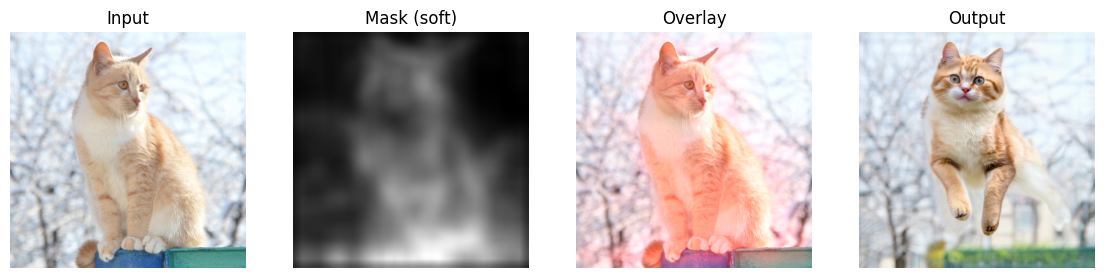

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from diffusers import StableDiffusion3Pipeline, FlowMatchEulerDiscreteScheduler
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import retrieve_timesteps


MODEL_ID = "stabilityai/stable-diffusion-3-medium-diffusers"
dtype = torch.float16

pipe = StableDiffusion3Pipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype,
    variant="fp16",
)
pipe.enable_model_cpu_offload()

if hasattr(pipe, "enable_vae_tiling"):
    pipe.enable_vae_tiling()

scheduler = FlowMatchEulerDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = scheduler

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"CUDA available. Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


img_path = "/kaggle/input/flowedit-main-implementation/FlowEdit/example_images/cat_ginger.png"
#/kaggle/input/flowedit-main-implementation/FlowEdit/example_images/cat_ginger.png
init_img = Image.open(img_path)
print("Image loaded")

IMG_SIZE = 512
x_src = encode_image_to_latents(pipe, init_img, size=IMG_SIZE)

src_prompt = "A cat sitting."
tar_prompt = "A cat jumping in the air"
negative_prompt = ""

edited_latents, mask_soft, mask_bin = FlowEditSD3_masked(
    pipe=pipe,
    scheduler=scheduler,
    retrieve_timesteps_fn=retrieve_timesteps,
    x_src=x_src,
    src_prompt=src_prompt,
    tar_prompt=tar_prompt,
    negative_prompt=negative_prompt,
    T_steps=50,
    n_avg=5,
    src_guidance_scale=3.5,
    tar_guidance_scale=19.5,
    n_min=10,
    n_max=45,
    #mask
    auto_mask=True,
    mask_strength=0.7,
    mask_n=14,
    mask_guidance=7.0,
    mask_blur_ks=5,
    mask_dilate_ks=0,
    mask_threshold=0.5,
)

out_img = decode_latents_to_pil(pipe, edited_latents)
out_img.save("flowedit_masked_out.png")
print("Saved:", "flowedit_masked_out.png")

if torch.cuda.is_available():
    torch.cuda.empty_cache()


if mask_soft is not None:
    m = upsample_mask_to_image(mask_soft.numpy(), out_size=IMG_SIZE)

    init_vis = init_img.convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    init_arr = np.array(init_vis).astype(np.float32) / 255.0

    overlay = init_arr.copy()
    overlay[..., 0] = np.clip(overlay[..., 0] + 0.6 * m, 0, 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 4, 1); plt.title("Input"); plt.imshow(init_arr); plt.axis("off")
    plt.subplot(1, 4, 2); plt.title("Mask (soft)"); plt.imshow(m, cmap="gray"); plt.axis("off")
    plt.subplot(1, 4, 3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
    plt.subplot(1, 4, 4); plt.title("Output"); plt.imshow(out_img); plt.axis("off")
    plt.show()